# Uporaba časovnih vrst / Time series analysis

Modeli časovnih vrst se uporabljajo za analizo in napovedovanje časovnih serij podatkov, ki imajo tipično neko ponavljajočo periodo oziroma vzorec (npr. letni). Kot primer bomo vzeli število potnikov v letalskem prometu. 

> The time series analysis is one of the statistical "powerhouse" tools as it (theoretically) allows us to
 predict samples from any data series available to us. The uses range from stock price prediction to
  weather forecast.
In this exercise we will present an example of air traffic passengers, and demonstrate the steps required to create and evaluate our predictions.



In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf  
import warnings
warnings.filterwarnings('ignore')

### Nalaganje in prikaz podatkov 


     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


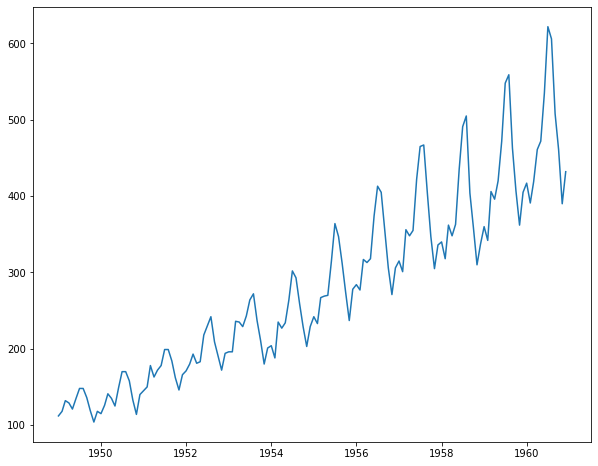

In [2]:
data = pd.read_csv('AirPassengers.csv')
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=True, index_col='Month',date_parser=dateparse)
print (data.head())

data.index
ts = data['#Passengers']
ts.head(10)
plt.figure(figsize=[10,8])
plt.plot(ts)
# plt.show()

## 1. Testiranje podatkov, stacionarnost

Naš cilj je doseči, da je serija vzorcev, ki jih opazujemo stacionarna. Zakaj? Zato ker v takem primeru lahko izdelamo model časovne vrste in ga uspešno uporabimo za napovedovanje naslednjih vzorcev.

Pri tem si lahko za začetek pomagamo z izrisom statistik ter z Dickey-Fuller testom, ki preverja nulto hipotezo, da je serija ni stacionarna.

Izris statistik : Najprej narišemo tekoče povprečje in tekočo standardno deviacijo. Kaj pomeni tekoče -> Pomeni, da gledamo povprečje v zadnji periodi. V našem primeru vzamemo za periodo 12 mesecev, ker iz originalnih podatkov vidimo da je trend letni.

Dickey/Fuller test: Pri tej statistiki so važne vrednosti vrednost-p, kritične vrednosti in statistika testa. Če je vrednost statistike manjša od kritične vrednosti lahko trdimo, da je serija vzorcev stacionarna.

> The principal requirement of the TS analysis is the stationarity of the input data - i.e. it must 
either grow / decline at a constant rate or follow a repeating pattern. 
One of the test that we can do to see whether or not the series is stationary is the Dickey-Fuller
 test implemented in the statsmodels library.
 

In [4]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=[10,8])
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    


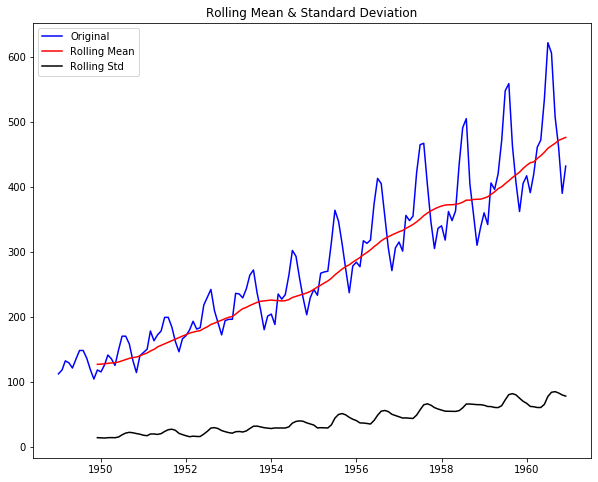

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [5]:
# Perform stationarity test and show results
test_stationarity(ts)

### Komentar
Če je rezultat Test Statistic manjši od 1/5/10% Critical Value, lahko rečemo da je 99/95/90% podatkov stacionarnih in torej primernih za analizo s časovnimi vrstami. 
 
### Vprašanje: 
Ali so originalni podatki stacionarni?


## 2. Odstranjevanje trendov
Če podatki niso stacionarni (in ponavadi niso) moramo poskusiti podatke umetno narediti stacionarne. Grobo gledano imamo na voljo dve možnosti: eliminacija trenda in opazovanje sezonskega trenda.


### Eliminacija trenda

Trend lahko odstranimo na več načinov:
* Na seriji uporabimo funkcijo, ki zmanjša obseg sprememb podatkov (log, koren itd.). V našem primeru bomo uporabili logaritem.
* Agregacija - uporabimo povprečje preko določene periode
* Glajenje - delamo s tekočim povprečjem
* Regresijski model
* Odvod

V našem primeru preizkusimo sledeče:
* X = (log(X)).rolling(12).mean() - logaritmiranje podatkov, povprečenje zadnjih 12 mesecev
* X = ewma(log(x)) - expotencialno uteženo tekoče povprečje
* X = log(X(t)) - log(X(t-shift)) - diferenciacija oziroma odvod vzorcev



### 2.1 Logaritmirani podatki, povprečje 12 mesecev

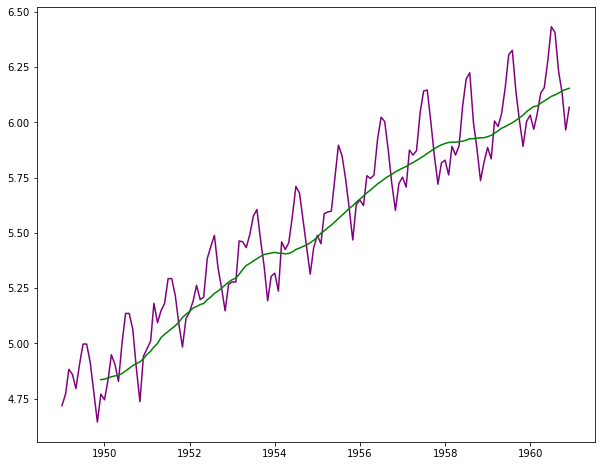

In [7]:
ts_log = np.log(ts)

# 12 month moving average
moving_avg = ts_log.rolling(12).mean()

plt.figure(figsize=[10,8])
plt.plot(ts_log, label="Log", color="purple")
plt.plot(moving_avg, color='green', label="Moving average")

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
1951-03-01    0.197694
1951-04-01    0.093955
1951-05-01    0.121101
1951-06-01    0.140570
Name: #Passengers, dtype: float64
Testing moving average difference


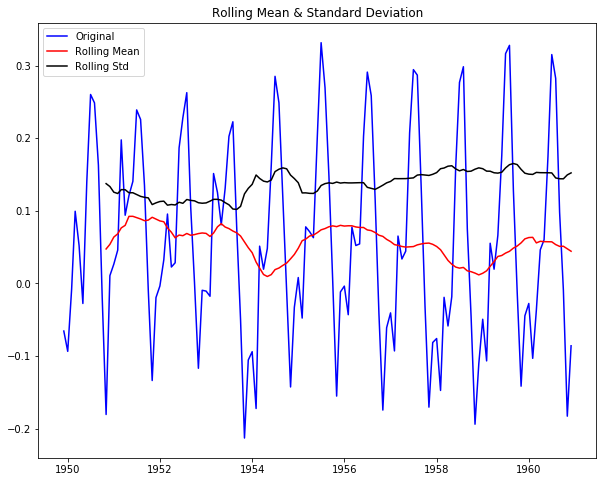

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [8]:
# Log series minus moving average
ts_log_moving_avg_diff = ts_log - moving_avg

# print out first 30 samples
print(ts_log_moving_avg_diff.head(30))

ts_log_moving_avg_diff.dropna(inplace=True)

print( "Testing moving average difference")
test_stationarity(ts_log_moving_avg_diff)

### Vprašanje

Opiši postopek, kako smo obdelali podatke (na podlagi kode). Kako je logaritem spremenil vrednosti podatkov ? 
Preveri graf obdelanih podatkov ter DF test in ugotovi, ali so podatki stacionarni. Kaj je potrebno pri tej obdelavi vedeti vnaprej? 



### 2.2 Eksponentno uteženo tekoče povprečje / Exponentially weighted moving average

Poskusimo narediti drugačno obdelavo: na logaritmiranih podatkih izračunamo eksponentno tekoče povprečje.

### Naloga 1: 
Nariši dobljene podatke in preveri stacionarnost z DF testom. Primerjaj rezultate testa (stacionarnost)


In [11]:
# Exponential weighted moving average
#expweighted_avg = ts_log.ewm(12).mean()

# plot moving average and log time series
#plt.figure(figsize=[10,8])

# New dataset for TS: log-ewma difference
#ts_log_ewma_diff = ts_log

print ("Testing exp. weighted average : ")
#test_stationarity(ts_log_ewma_diff)



Testing exp. weighted average



### 2.3 Odštevanje vzorcev / Differencing

Z odštevanjem zaporednih vzorcev lahko odpravimo sezonske spremembe in trende.

> If we suspect that our data includes seasonal patterns we can use additional tools in our arsenal. 
The first is *differencing* which tries to remove seasonality and trends at the same time by 
subtracting a shifted version of data from the original.

* X = log(X(t)) - log(X(t-shift))

### Naloga 2
Izriši dobljene podatke in preveri stacionarnost. 

In [15]:
# Sample difference: difference between two succesive samples
ts_log_diff = ts_log - ts_log.shift()

# Izpis podatkov

plt.figure(figsize=[10,8])
#plt.plot(ts_log_diff)

# Odstranimo 
ts_log_diff.dropna(inplace=True)
print ("testing difference: log - shifted log")

#test_stationarity(ts_log_diff)

testing difference: log - shifted log


<Figure size 720x576 with 0 Axes>


### 2.4 Dekompozicija podatkov / Seasonal decomposition

Orodje sezonska dekompozicija razdeli podatke v tri serije: trend, sezonskost, ter preostanek (residual). S časovnimi vrstami potem izdelamo model tega preostanka. 

We therefore use a more powerfull tool - *Seasonal decomposition*, which splits the data into three series:
* trend - the data that we simply add to predictions
* seasonal data - the seasonal changes
* residual - the remaining noise - data we will be trying to predict

### Naloga 3
Izriši dobljene časovne serije in preveri stacionarnost za trend, seasonal ter preostanek (residual) ter primerjaj z ostalimi metodami. 

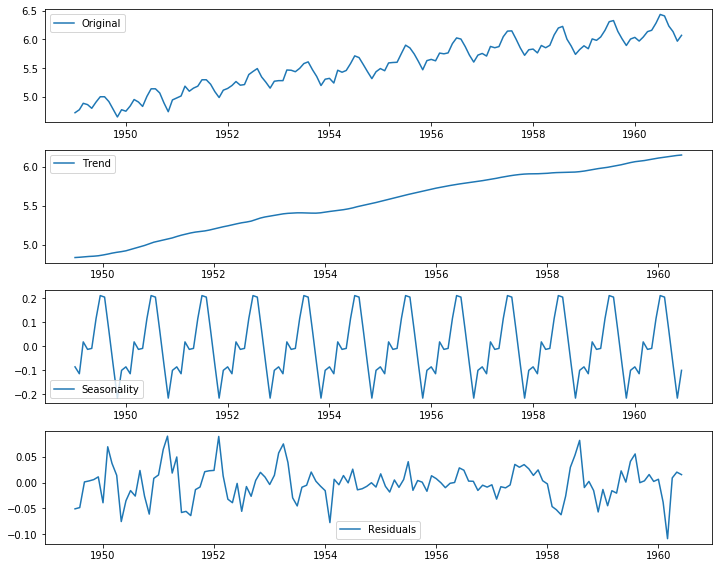

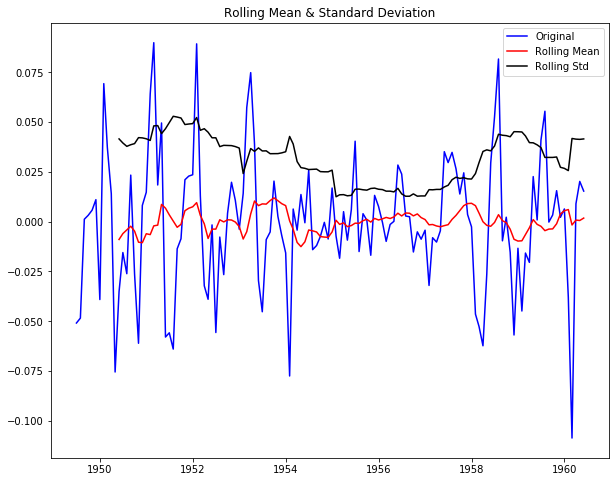

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [62]:
# Perform decomposition
decomposition = seasonal_decompose(ts_log)

# Three resulting time series:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=[10,8])
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# This is our new dataset : residual data after trend and seasonality elemination
ts_log_decompose = residual

# Test stationarity:
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)



## 3. Gradnja ARIMA modela / Building a Time Series ARIMA model

Ko smo serijo naredili stacionarno, lahko izdelamo model. Model se imenuje ARIMA in potrebuje tri podatke:
* p - koliko podatkov uporabimo za napoved
* q - koliko napak upoštevamo pri izračuni napovedi
* d - stopnja odvoda, ki jo uporabimo



> AutoRegressive Integrated Moving Average Model (ARIMA) model adds differencing to an ARMA model. Differencing subtracts the current value from the previous and can be used to transform a time series into one that’s stationary. 
Three integers (p, d, q) are typically used to parametrize ARIMA models.

* p: number of autoregressive terms (AR order), which is the number of previous samples
* d: number of nonseasonal differences (differencing order)
* q: number of moving-average terms (MA order)

We have already determined the d parameter by using a differentiated dataset - each level of differencing equals 
to +1 to the value of the *d* parameter. We can therefore either use the original data and set *d* to 1 
or use the ``ts_log_diff`` and set it to 0.

#### Avtokorelacijska funkcija

The other two parameters must be determined from the AutoCorrelation function (ACF) and the Partial Autocorrelation 
function (PACF) shown here:

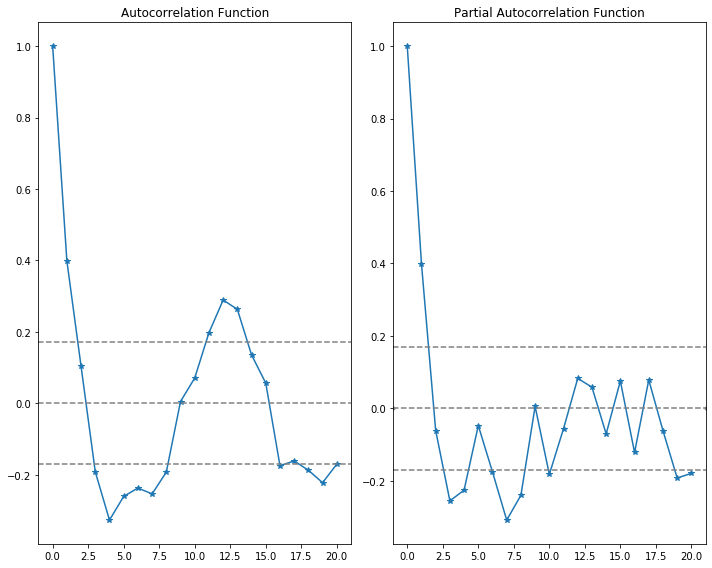

In [63]:
# We set input data: residuals, without seasonality and trend
in_data = ts_log_decompose

# Autocorrelation function
lag_acf = acf(in_data, nlags=20)
# Partial Autocorrelation function
lag_pacf = pacf(in_data, nlags=20, method='ols')


plt.figure(figsize=[10,8])
#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf, marker='*')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(in_data)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(in_data)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf, marker='*')
plt.axhline(y=0,linestyle='--',color='gray', marker='.')
plt.axhline(y=-1.96/np.sqrt(len(in_data)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(in_data)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

To set the *p* and *q* values we must find the x value of the point in which the ACF (for *q*) and PACF (for *p*) falls bellow the confidence interval for the first time (i.e. bellow the upper dotted line).

We can see that in our example this means 2 for both funtions.

Our ideal model would therefore be *p=2,d=0,q=2*.
We can now start creating our models and show some examples. Each case will also feature the Residual sum of squares as it's score - the lower the better.

## Primer: Modeli za podatke sezonske dekompozicije / Building TS models on seasonal decomposition residual data.

We will use seasonal decomposition. Model will predict residual (error) data after subtracting trends and seasonality.

### 3.1 AR model
We first fit AR model to the data. This model ignores any errors and has therefore it's *q* set to 0.

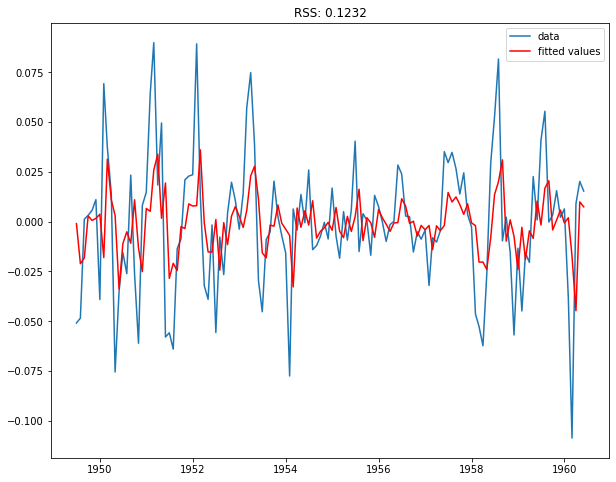

In [64]:
# AR model:
model = ARIMA(in_data, order=(2, 0, 0))  

# Resulting AR time series
results_AR = model.fit(disp=-1) 


plt.figure(figsize=[10,8])
plt.plot(in_data, label="data")
plt.plot(results_AR.fittedvalues, color='red', label="fitted values")
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-in_data)**2))
plt.legend(loc='best')
plt.show()

### 3.2 MA model
The next is the opposite model which focuses only on the error - the MA model.

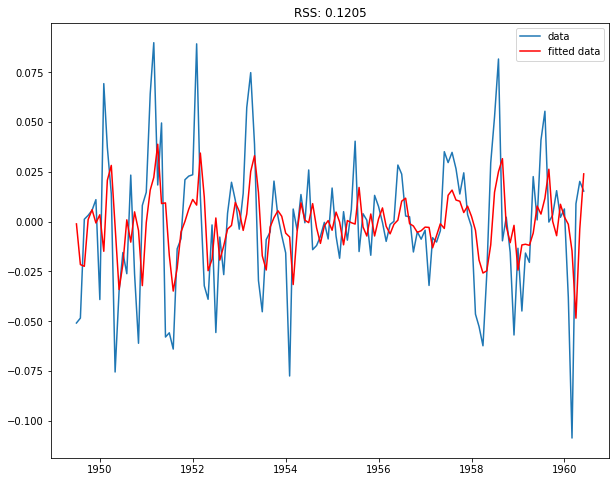

In [65]:
# MA model:
model = ARIMA(in_data, order=(0, 0, 2))  
results_MA = model.fit(disp=-1)  

plt.figure(figsize=[10,8])
plt.plot(in_data, label="data")
plt.plot(results_MA.fittedvalues, color='red', label="fitted data")
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-in_data)**2))
plt.legend(loc='best')
plt.show()

### 3.3 ARIMA model

And last the model that we defined as "best" - The ARIMA model.

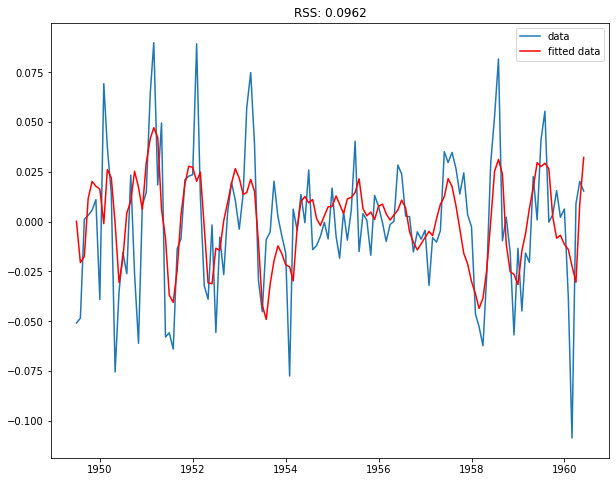

In [70]:
# ARIMA model:
model = ARIMA(in_data, order=(3, 0, 2))  
results_ARIMA = model.fit(disp=-1)


plt.figure(figsize=[10,8])
plt.plot(in_data, label="data")
plt.plot(results_ARIMA.fittedvalues, color='red', label="fitted data")
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-in_data)**2))
plt.legend(loc='best')
plt.show()


We can now calculate the difference between the real values and the predicted values using the head() command.

In [71]:
print (results_ARIMA.fittedvalues.head(10))

Month
1949-07-01    0.000163
1949-08-01   -0.020557
1949-09-01   -0.017472
1949-10-01    0.011536
1949-11-01    0.020201
1949-12-01    0.017789
1950-01-01    0.016319
1950-02-01   -0.000984
1950-03-01    0.026181
1950-04-01    0.021979
dtype: float64


This code calculates predictions of airplane passengers from ARIMA predicted time series, adding back seasonality and trend, and removing logarithm. Plot the predicted vs. true values.

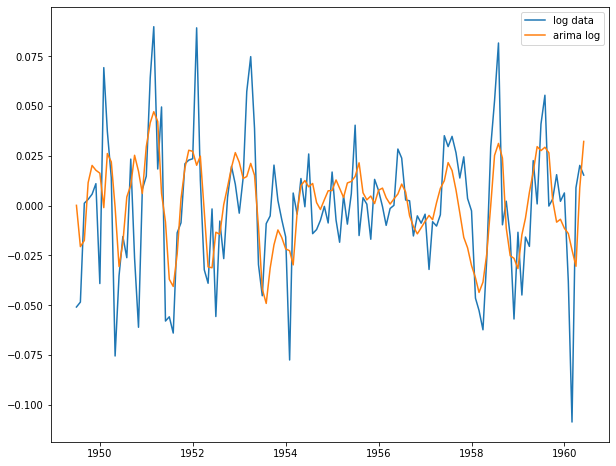

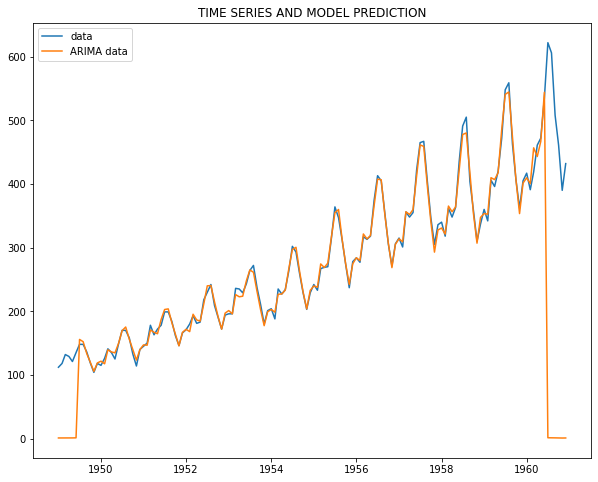

In [76]:
# Fitted *predicted values: result of the ARIMA model
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

# OPTIONAL TEST: if we take as predictions all 0
# uncomment
#  predictions_ARIMA_diff = pd.Series(0, index=in_data.index)

# ARIMA_diff are the model's predicted values in log space
predictions_ARIMA_log = predictions_ARIMA_diff

# predictions_ARIMA_log[:] = 0.0

# print values
predictions_ARIMA_log.head()


plt.figure(figsize=[10,8])
plt.plot(in_data, label = "log data")
plt.plot(predictions_ARIMA_log, label = "arima log")
plt.legend(loc='best')
plt.show()

# add trend and seasonality in log domain
predictions_ARIMA_log = predictions_ARIMA_log.add(trend,fill_value=0)
predictions_ARIMA_log = predictions_ARIMA_log.add(seasonal,fill_value=0)

# exponential of log predictions: get time series prediction
predictions_ARIMA = np.exp(predictions_ARIMA_log)

# plot predictions of passengers in real values
plt.figure(figsize=[10,8])

plt.plot(ts, label="data")
plt.plot(predictions_ARIMA, label="ARIMA data")

# Ogled dela napovedi
#plt.plot(ts[100:120], label="data")
#plt.plot(predictions_ARIMA[100:120], label="ARIMA data")

plt.title('TIME SERIES AND MODEL PREDICTION')
plt.legend(loc='best')
plt.show()

In [77]:
error_ser = predictions_ARIMA[10:(len(ts)-10)]-ts[10:(len(ts)-10)]
rmse = np.sqrt(sum(error_ser**2)/len(error_ser))

print("Root mean sqaures error : ", rmse)

Root mean sqaures error :  6.7208965827406875



### Naloga 5
Spreminjaj parametre p, q pri ARIMA modelu (vključi tudi AR in MA) in preveri napoved ter napako, prikaži v tabeli. 

### Dodatna naloga 6 (Bonus)
Izdelaj ARIMA model še za en drug primer vhodnih podatkov ( log-povprecje, EWMA, ali log-diference), izračunaj napoved števila potnikov, in preveri RMSE napako ter primerjaj z rezultati zgoraj. 